# Extractive Text Summarization

Text summarization involves creating a shorter version of a text that retains its key information. While humans are able to understand the main points of a text by simply reading it, machines can also perform this task through the use of natural language processing (NLP)

There are two techniques for summarizing text:

**Extractive summarization**: involves identifying and extracting the most important sentences from the original text. Extractive summarization is easier to implement and can be done quickly using an unsupervised approach that does not require prior training.

**Abstractive summarization**: involves understanding the main ideas of the text and generating a new, summarized version based on that understanding. Abstractive summarization has the advantage of being able to generate new text, but it is more complex to implement and requires language generation capabilities.

This Notebook will delve further into the topic of **extractive summarization**.

## Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import sent_tokenize
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer
import spacy
import pytextrank

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# !pip install pytextrank
# !python -m spacy download en_core_web_sm
# !pip install rouge-score

## Import data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Text Mining Project/raw_data.csv')

In [5]:
df.head()

,category,article_id,text,summary
0,business,73,German growth goes into reverse\n \n Germany's...,The figures confounded hopes of a 0.2% expansi...
1,business,352,Share boost for feud-hit Reliance\n \n The boa...,The board of Indian conglomerate Reliance has ...
2,business,279,German bidder in talks with LSE\n \n Deutsche ...,"Deutsche Boerse bosses have held ""constructive..."
3,business,447,News Corp eyes video games market\n \n News Co...,"According to the Financial Times, chief operat..."
4,business,242,Q&A: Malcolm Glazer and Man Utd\n \n The battl...,"In October 2004, Manchester United said they h..."


In [6]:
df.shape

(2224, 4)

In [7]:
df['text'].iloc[0]

"German growth goes into reverse\n \n Germany's economy shrank 0.2% in the last three months of 2004, upsetting hopes of a sustained recovery.\n \n The figures confounded hopes of a 0.2% expansion in the fourth quarter in Europe's biggest economy. The Federal Statistics Office said growth for the whole of 2004 was 1.6%, after a year of contraction in 2003, down from an earlier estimate of 1.7%. It said growth in the third quarter had been zero, putting the economy at a standstill from July onward. Germany has been reliant on exports to get its economy back on track, as unemployment of more than five million and impending cuts to welfare mean German consumers have kept their money to themselves. Major companies including Volkswagen, DaimlerChrysler and Siemens have spent much of 2004 in tough talks with unions about trimming jobs and costs. According to the statistics office, Destatis, rising exports were outweighed in the fourth quarter by the continuing weakness of domestic demand.\n 

In [8]:
# removing nans if any
df.dropna(inplace=True)
df.isnull().sum()

category      0
article_id    0
text          0
summary       0
dtype: int64

## Data Analysis and EDA

<function matplotlib.pyplot.show(close=None, block=None)>

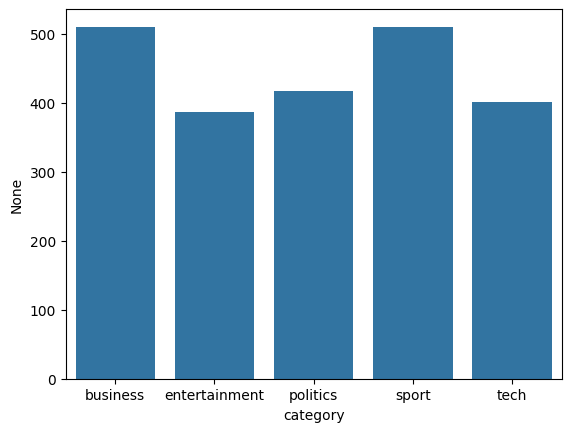

In [9]:
category_sizes = df.groupby('category').size()
sns.barplot(x=category_sizes.index, y=category_sizes)
plt.show

In [10]:
# Function to count the number of words in a text
def count_words(text):
    return len(text.split())

df['text_length'] = df['text'].apply(count_words)
df['summary_length'] = df['summary'].apply(count_words)
df.head(2)

,category,article_id,text,summary,text_length,summary_length
0,business,73,German growth goes into reverse\n \n Germany's...,The figures confounded hopes of a 0.2% expansi...,253,104
1,business,352,Share boost for feud-hit Reliance\n \n The boa...,The board of Indian conglomerate Reliance has ...,146,49


In [11]:
df['article_id'] = df['article_id'].apply(lambda x: str(x))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2224 entries, 0 to 2223
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   category        2224 non-null   object
 1   article_id      2224 non-null   object
 2   text            2224 non-null   object
 3   summary         2224 non-null   object
 4   text_length     2224 non-null   int64 
 5   summary_length  2224 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 104.4+ KB


In [12]:
category_length = df.groupby('category',0).agg({'text_length':'mean', 'summary_length':'mean'})
category_length

,text_length,summary_length
category,,
business,328.880392,139.929412
entertainment,330.621762,144.049223
politics,453.973621,195.709832
sport,329.039216,143.078431
tech,502.695761,213.837905


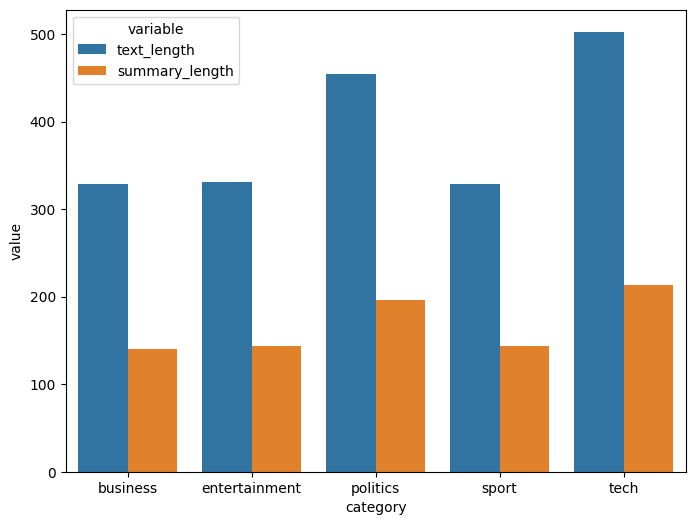

In [13]:
df_m = pd.melt(category_length, ignore_index=False)
plt.figure(figsize=(8,6))
sns.barplot(x=df_m.index, y="value", hue='variable', data=df_m)
plt.show()

In [14]:
pd.melt(category_length, ignore_index=False).groupby('variable').mean()

,value
variable,
summary_length,167.320961
text_length,389.042150


## Text summarization using PyTextRank and spaCy modules

spaCy is a free, open-source library for advanced Natural Language Processing (NLP) in Python.

PyTextRank is an implementation of TextRank graph algorithm in Python for use in spaCy pipelines which provides fast, effective phrase extraction from texts, along with extractive summarization.

In [15]:
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('textrank')

In [16]:
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'textrank']

In [17]:
# nlp.Defaults.stop_words

**Note**

**en_core_web_sm** is a small English pipeline trained on written web text (blogs, news, comments), that includes vocabulary, syntax and entities. English pipeline optimized for CPU.

Components: tok2vec, tagger, parser, senter, ner, attribute_ruler, lemmatizer.

Text summarization typically involves extracting the most important information from a document to create a concise and coherent summary. The key components for text summarization often include tokenization, part-of-speech tagging, parsing, and potentially additional components like the TextRank algorithm for identifying important sentences.

Despite this we keep 'ner' step in a pipeline, because it give slightly better result

In [18]:
df['processed_text'] = df['text'].apply(lambda row: nlp(row))

We will summarize based on top 20 phrases for article, yielding its top 5 sentences.

In [19]:
def apply_textrank(doc):
    tr = doc._.textrank
    summary_generator = tr.summary(limit_phrases=20, limit_sentences=5)

    # convert the generator object to a list and convert each element to string
    summary_text = ' '.join(str(item) for item in list(summary_generator))
    return summary_text

In [20]:
df['textrank_summary'] = df['processed_text'].apply(apply_textrank)

In [21]:
df[['text', 'textrank_summary', 'summary']][:3]

,text,textrank_summary,summary
0,German growth goes into reverse\n \n Germany's...,"Eurozone interest rates are at 2%, but senior ...",The figures confounded hopes of a 0.2% expansi...
1,Share boost for feud-hit Reliance\n \n The boa...,Share boost for feud-hit Reliance\n \n The boa...,The board of Indian conglomerate Reliance has ...
2,German bidder in talks with LSE\n \n Deutsche ...,"But, Hans Reckers, a board member of Germany's...","Deutsche Boerse bosses have held ""constructive..."


In [22]:
def rouge_bleu_eval(ref_summary, exctracted_summary):

  scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
  rouge_scores = [scorer.score(ref, hyp) for ref, hyp in zip(ref_summary, exctracted_summary)]
  average_rouge = {
      'rouge1': sum(score['rouge1'].fmeasure for score in rouge_scores) / len(rouge_scores),
      'rougeL': sum(score['rougeL'].fmeasure for score in rouge_scores) / len(rouge_scores),
  }

  bleu_score = corpus_bleu([[ref.split()] for ref in ref_summary], [gen.split() for gen in exctracted_summary])

  return average_rouge, bleu_score

In [23]:
average_rouge, bleu_score = rouge_bleu_eval(df['summary'], df['textrank_summary'])

In [24]:
print(f"Average Rouge-1: {average_rouge.get('rouge1'):.3f}, Average Rouge-L: {average_rouge.get('rougeL'):.3f}")
print(f"BLEU Score: {bleu_score:.3f}")


Average Rouge-1: 0.628, Average Rouge-L: 0.424
BLEU Score: 0.404


The average **Rouge-1** score of **0.628** and the average Rouge-L score of **0.424** suggest that, on average, there is a moderate to good overlap between the generated summaries and the reference summaries.

**Rouge-1**: Measures overlap of unigrams (single words). A score of **0.628** indicates that, on average, over half of the unigrams in the generated summaries match those in the reference summaries.

**Rouge-L**: Measures the longest common subsequence. A score of **0.424** suggests that, on average, there is a good overlap in terms of the longest common subsequences between the generated and reference summaries.

However, the interpretation of Rouge scores can vary depending on the specific domain and the nature of summarization task. Rouge scores provide a quantitative measure of similarity but may not capture all aspects of summary quality. It's often useful to complement automated metrics with human evaluation to obtain a more comprehensive understanding of the generated summaries' quality.

The **BLEU** score is a metric for evaluating the quality of machine-generated text by comparing it to a set of reference texts. The BLEU score ranges from 0 to 1, where a higher score indicates better similarity to the reference texts.

**BLEU** score of **0.404** says that there is some overlap between the exctracted summaries and the reference summaries, but there is room for improvement.

In [27]:
df.to_csv('/content/drive/MyDrive/Text Mining Project/extSumm_text.csv', index=False)

In [5]:
# df_saved = pd.read_csv('/content/drive/MyDrive/Text Mining Project/extSumm_text.csv')